# Environment Setup

In [1]:
#!pip install fathomnet numpy pyyaml scikit-learn ultralytics

In [2]:
import cv2
import numpy as np
import os
import shutil
import torch
import torchvision
import xml.etree.ElementTree as ET
import yaml

from IPython.display import Image, display
from ipywidgets import IntProgress
from sklearn.model_selection import train_test_split
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ultralytics import YOLO
from ultralytics.engine.results import Boxes

Helpful variables for training and for file locations

In [3]:
fresh_mode = False

data_directory = os.path.join('datasets', 'sea_data') # Where will you save the dataset

# Separate directories for images and labels
img_dir = os.path.join(data_directory, 'images') 
label_dir = os.path.join(data_directory, 'labels')


## Download and Format Images 

Decide below which "concepts" to include. These are the classes you want to be able to identify.

In [4]:
# Missing Mollusca & Nemertea

concepts_to_include = [
    'Annelida',
    'Ascidiacea',
    'Asteroidea',
    'Ceriantharia',
    # 'Cn
    'Crinoidea',
    'Echinoidea',
    'Gastropoda',
    'Hexacorallia',
    'Holothuroidea',
    'Octocorallia',
    'Ophiuroidea',
    'Porifera',
    'Pycnogonida',
]

Using fathomnet's api we can look and see the number of bounding boxes present in fathomnet for each species

In [5]:
count_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --count'
if fresh_mode: 
    !{count_command}

Some of these are too low to use in our training, so for those less than 100 bounding boxes we will remove them from the included list

In [6]:
too_few_bboxes = ['Annelida','Ascidiacea', 'Echinoidea', 'Pycnogonida']

concepts_to_include = [concept for concept in concepts_to_include if concept not in too_few_bboxes]
concepts_to_include

['Asteroidea',
 'Ceriantharia',
 'Crinoidea',
 'Gastropoda',
 'Hexacorallia',
 'Holothuroidea',
 'Octocorallia',
 'Ophiuroidea',
 'Porifera']

Now, we can actually download the images from fathomnet

In [7]:
# Download the images from the fathomnet database
install_command = f'fathomnet-generate -c "{",".join(concepts_to_include)}" --format voc --img-download "{img_dir}" --output "{label_dir}"'
if fresh_mode: 
    !{install_command}

Let's take a look at a sample of these images and with their bounding boxes

In [8]:
def parseXml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bbox_pair = []

    for obj in root.findall('object'):
        name_key = obj.find('name').text
    
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        bbox_pair.append((name_key, (xmin, ymin, xmax, ymax)))
    
    return bbox_pair

In [9]:
def draw_boxes(image, bboxes):    
    for label, (x1, y1, x2, y2) in bboxes:
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

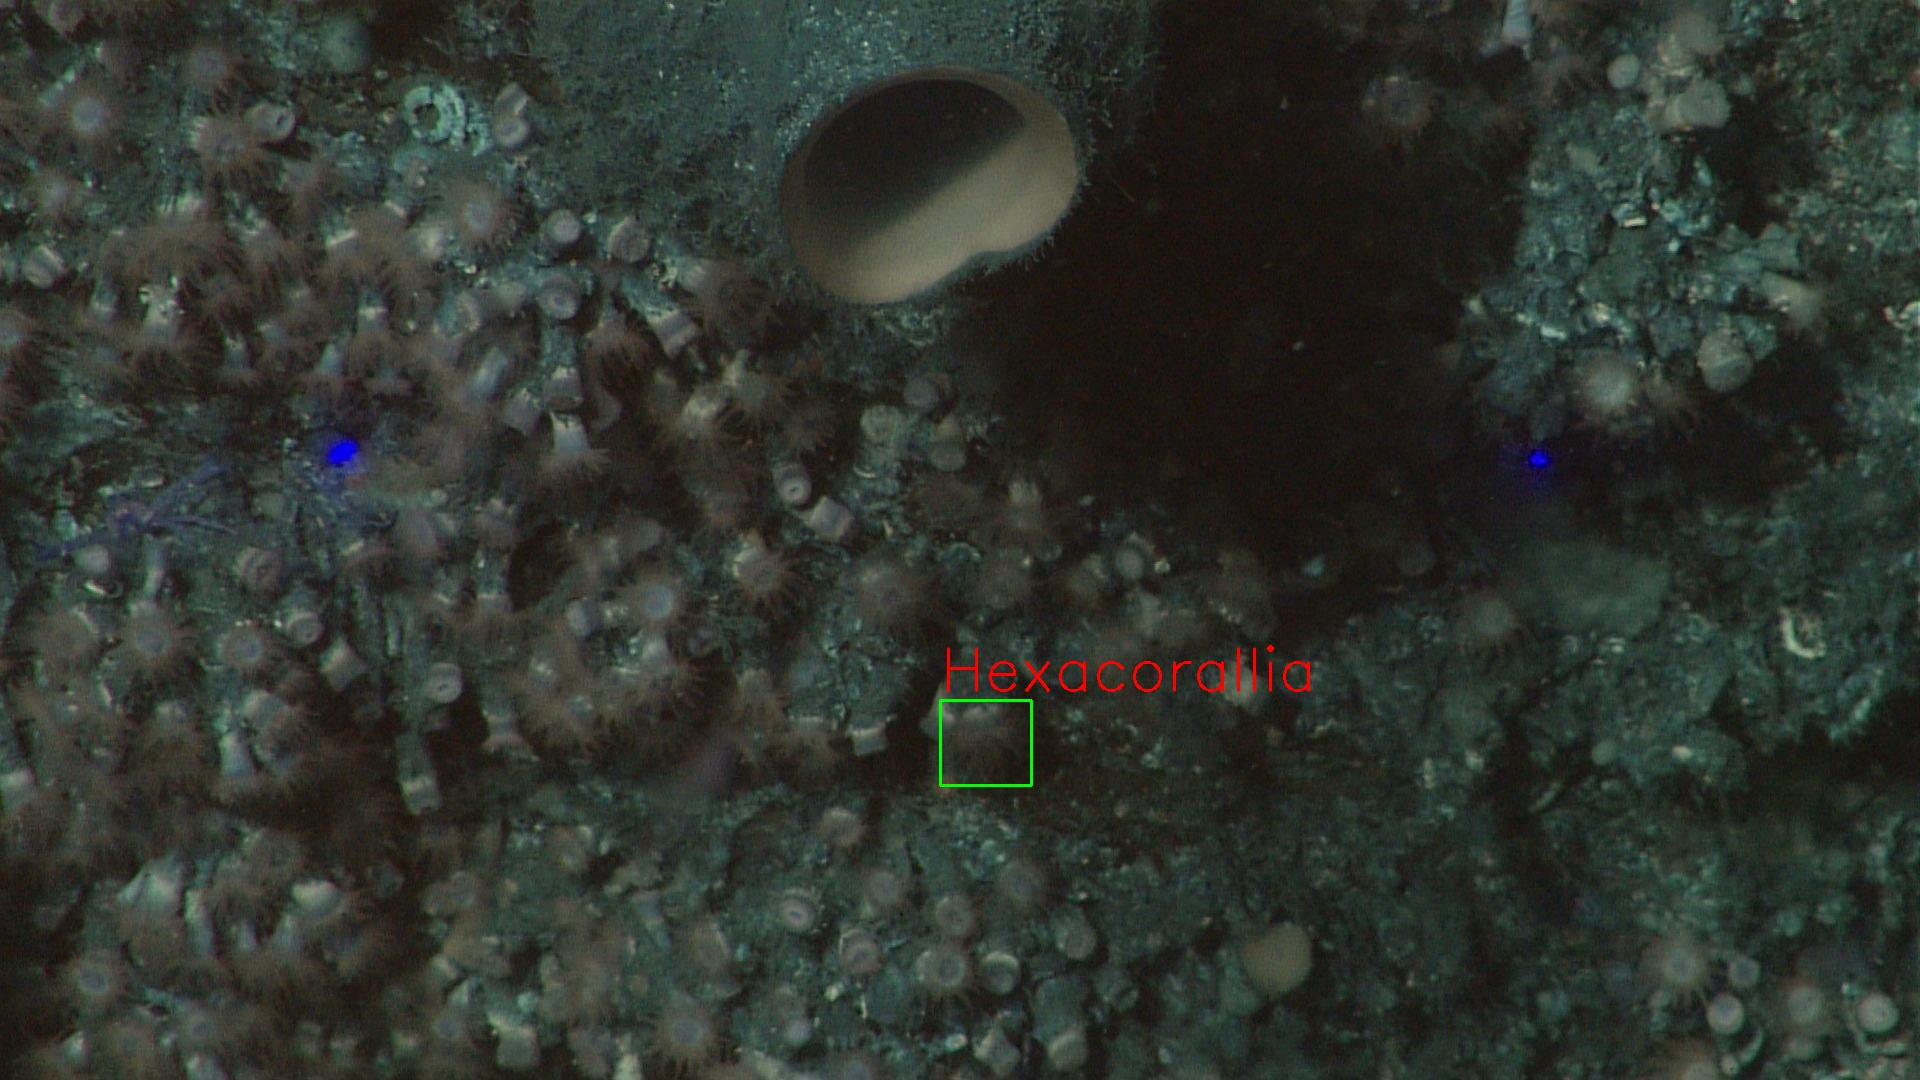

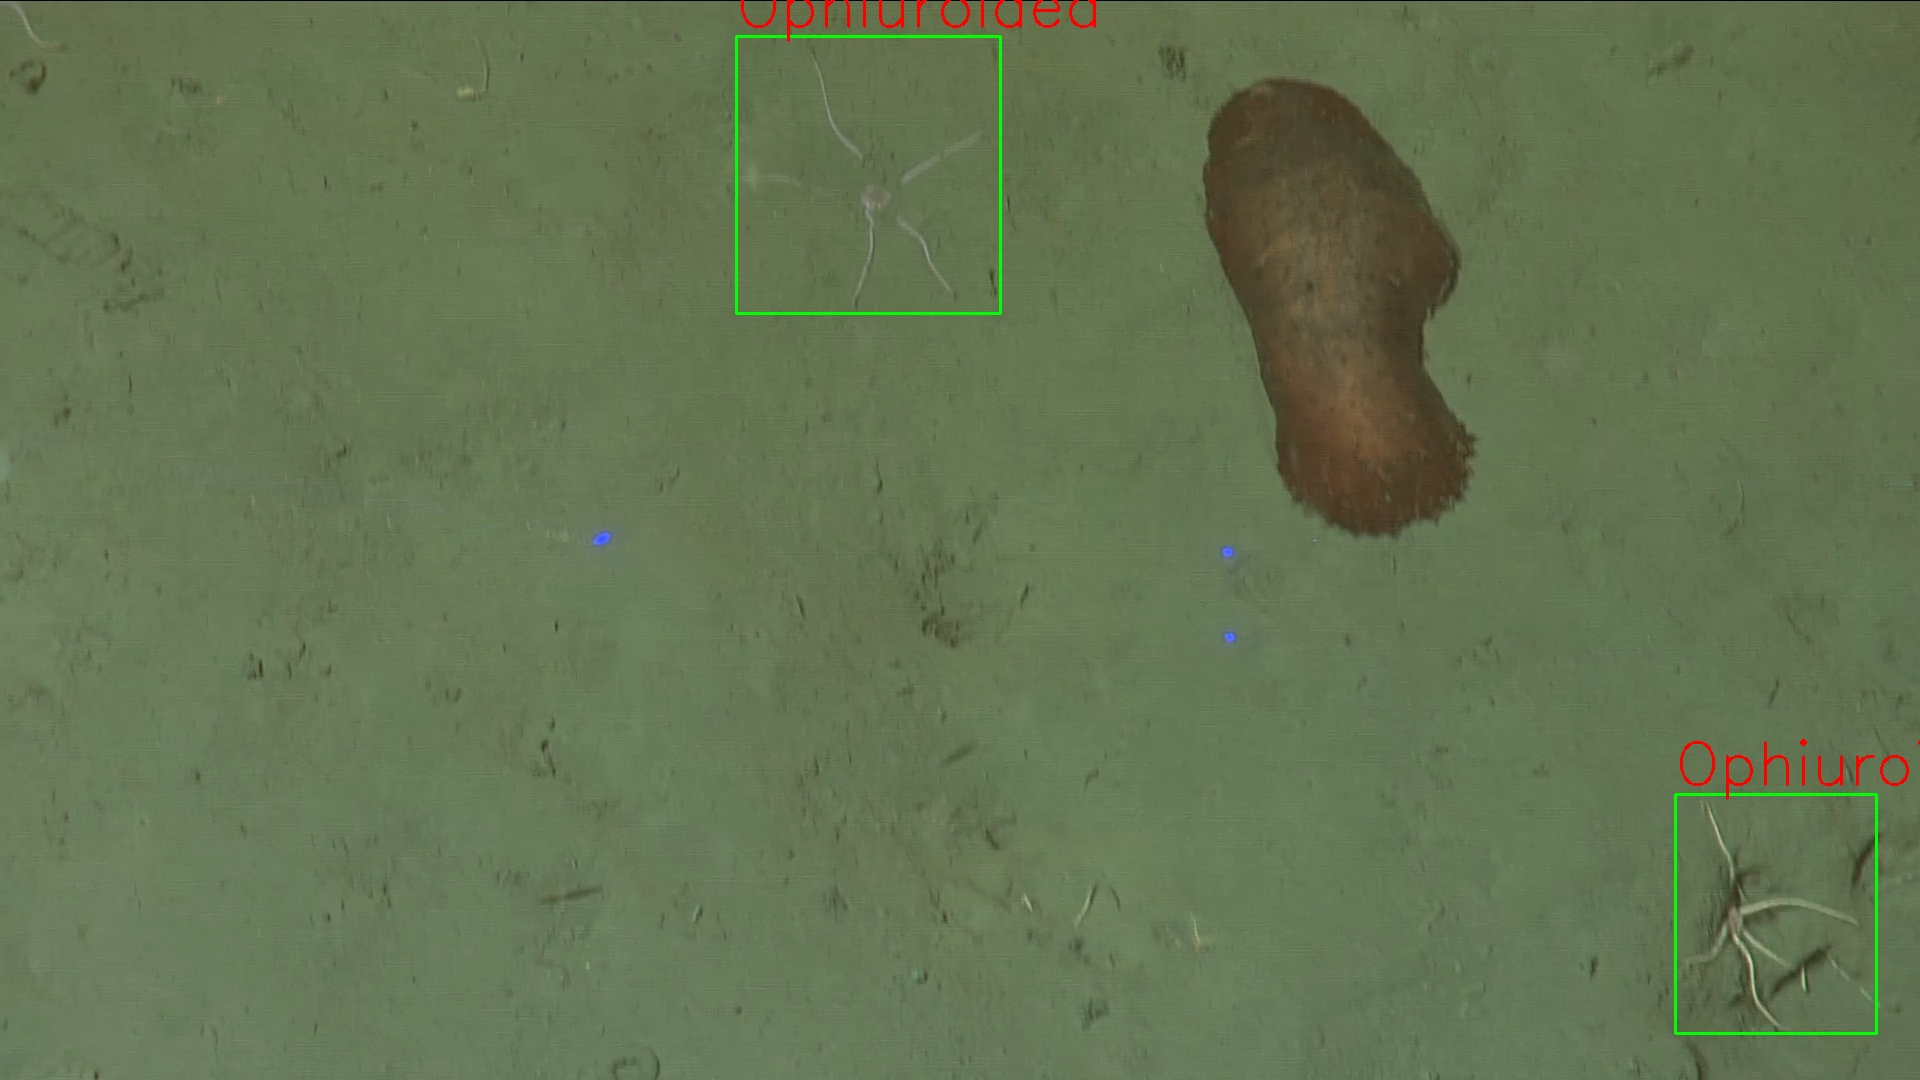

In [10]:
number_to_choose = 2
random_seed = 80
np.random.seed(random_seed)

image_dir = os.path.join(data_directory, 'images')
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]


random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, _ = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parseXml(os.path.join(data_directory, 'labels', f"{uid}.xml"))
    
    draw_boxes(image, bboxes)

## Break into train-val-test split

For this experiment we are going to use a train-val-test split of 70%-20%-10%

Since images are encoded using uuid4 we know that there is no order to the downloaded images this means that we can just move the first 70% of each concept into a training directory and so on.
We want to do this by concept so that we ensure that each concept is well represented in our training set.

### Split into concepts

In [11]:
label_directory = os.path.join(data_directory, 'labels')

concept_names = {}
# for filename in os.listdir(label_directory):
#     if not filename.endswith('.xml'): continue
#         
#     xml_file_path = os.path.join(label_directory, filename)
#     root_name, _ = os.path.splitext(filename)
# 
#     tree = ET.parse(xml_file_path)
#     root = tree.getroot()
# 
#     for obj in root.findall('.//object'):
#         name = obj.find('name').text
#         if name not in concept_names:
#             concept_names[name] = set()
#         
#         concept_names[name].add(root_name)
#             
# for concept, names in concept_names.items():
#     print(f'Concept: {concept} ::: {len(names)}')

### Move Images for training

In [12]:
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

def create_yaml_file(yaml_name='data'):
    data = {
        "path": 'sea_data',
        "train": [os.path.join('images', train_dir)],
        "val": [os.path.join('images', val_dir)],
        "test": [os.path.join('images', test_dir)],
        "names": {str(idx): class_name for idx, class_name in enumerate(concepts_to_include)}
    }

    with open(os.path.join(data_directory, f"{yaml_name}.yaml"), "w") as yaml_file:
        yaml.dump(data, yaml_file, default_flow_style=False)

if fresh_mode: create_yaml_file()

In [13]:
def copyImageToLocation(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'images')
    src_file = os.path.join(curr_location, f"{uid}.png")

    file_exists = os.path.isfile(os.path.join(curr_location, f"{uid}.png"))
    if not file_exists: return

    os.makedirs(os.path.join(curr_location, dest_dir), exist_ok=True)
    dest_file = os.path.join(curr_location, dest_dir, f"{new_id}.png")

    shutil.copy(src_file, dest_file)

In [14]:
def createTxtFile(uid, new_id, dest_dir=train_dir):
    curr_location = os.path.join(data_directory, 'labels')

    source_path = os.path.join(curr_location, f'{uid}.xml')
    
    tree = ET.parse(source_path)
    root = tree.getroot()

    file_destination = os.path.join(curr_location, dest_dir)
    os.makedirs(file_destination, exist_ok=True)

    image = cv2.imread(os.path.join(image_dir, dest_dir, f"{new_id}.png"))
    try:
        img_height, img_width, _ = image.shape
    except:
        os.remove(os.path.join(image_dir, dest_dir, f"{new_id}.png"))
        os.remove(os.path.join(image_dir, f"{uid}.png"))
        os.remove(os.path.join(curr_location, f"{uid}.xml"))
        return

    destination_path = os.path.join(file_destination, f'{new_id}.xml')
    shutil.copy(source_path, destination_path)

    with open(os.path.join(file_destination, f'{new_id}.txt'), 'w') as txt_file:
        for obj in root.findall('.//object'):
            name_key = concepts_to_include.index(obj.find('name').text)
    
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            xcenter_norm = ((xmin + xmax) / 2) / img_width
            ycenter_norm = ((ymin + ymax) / 2) / img_height
            width_norm = (xmax - xmin) / img_width
            height_norm = (ymax - ymin) / img_height
            
    
            line = f"{name_key} {xcenter_norm:6f} {ycenter_norm:6f} {width_norm:6f} {height_norm:6f}"
            txt_file.write(line + '\n')

In [15]:
max_images = 9182

progress = IntProgress(min=0, max=max_images)
display(progress)

def createNewFiles(files, target_dir=train_dir):
    for file in files:
        progress.value += 1
        copyImageToLocation(file, "{:08d}".format(img_index), target_dir)
        createTxtFile(file, "{:08d}".format(img_index), target_dir)

IntProgress(value=0, max=9182)

In [16]:
train_size = 0.7
val_size = 0.2
test_size = 0.1

if fresh_mode:
    for _, file_list in concept_names.items():
        train_files, test_and_val_files = train_test_split(list(file_list), test_size=(val_size+test_size), random_state=random_seed)
        val_files, test_files = train_test_split(test_and_val_files, test_size=(test_size / (test_size + val_size)), random_state=random_seed)
    
        createNewFiles(train_files, train_dir)
        createNewFiles(val_files, val_dir)
        createNewFiles(test_files, test_dir)

### Image Samples

In [17]:
def get_corners(mid_norm, dist_norm, dist_abs):
    top_corner_abs = int((mid_norm - dist_norm / 2) * dist_abs)
    bot_corner_abs = int((mid_norm + dist_norm / 2) * dist_abs)
    return top_corner_abs, bot_corner_abs

def parse_txt(text_path, image_size):
    h, w, _ = image_size    
    bbox_pair = []
    
    with open(text_path, 'r') as file:
        for line in file:
            parts = line.strip().split()

            label = concepts_to_include[int(parts[0])]
            x_mid, y_mid, w_norm, h_norm = map(float, parts[1:])
                    
            x0, x1 = get_corners(x_mid, w_norm, w)
            y0, y1 = get_corners(y_mid, h_norm, h)
                
            bbox_pair.append((label, (x0, y0, x1, y1)))

    return bbox_pair

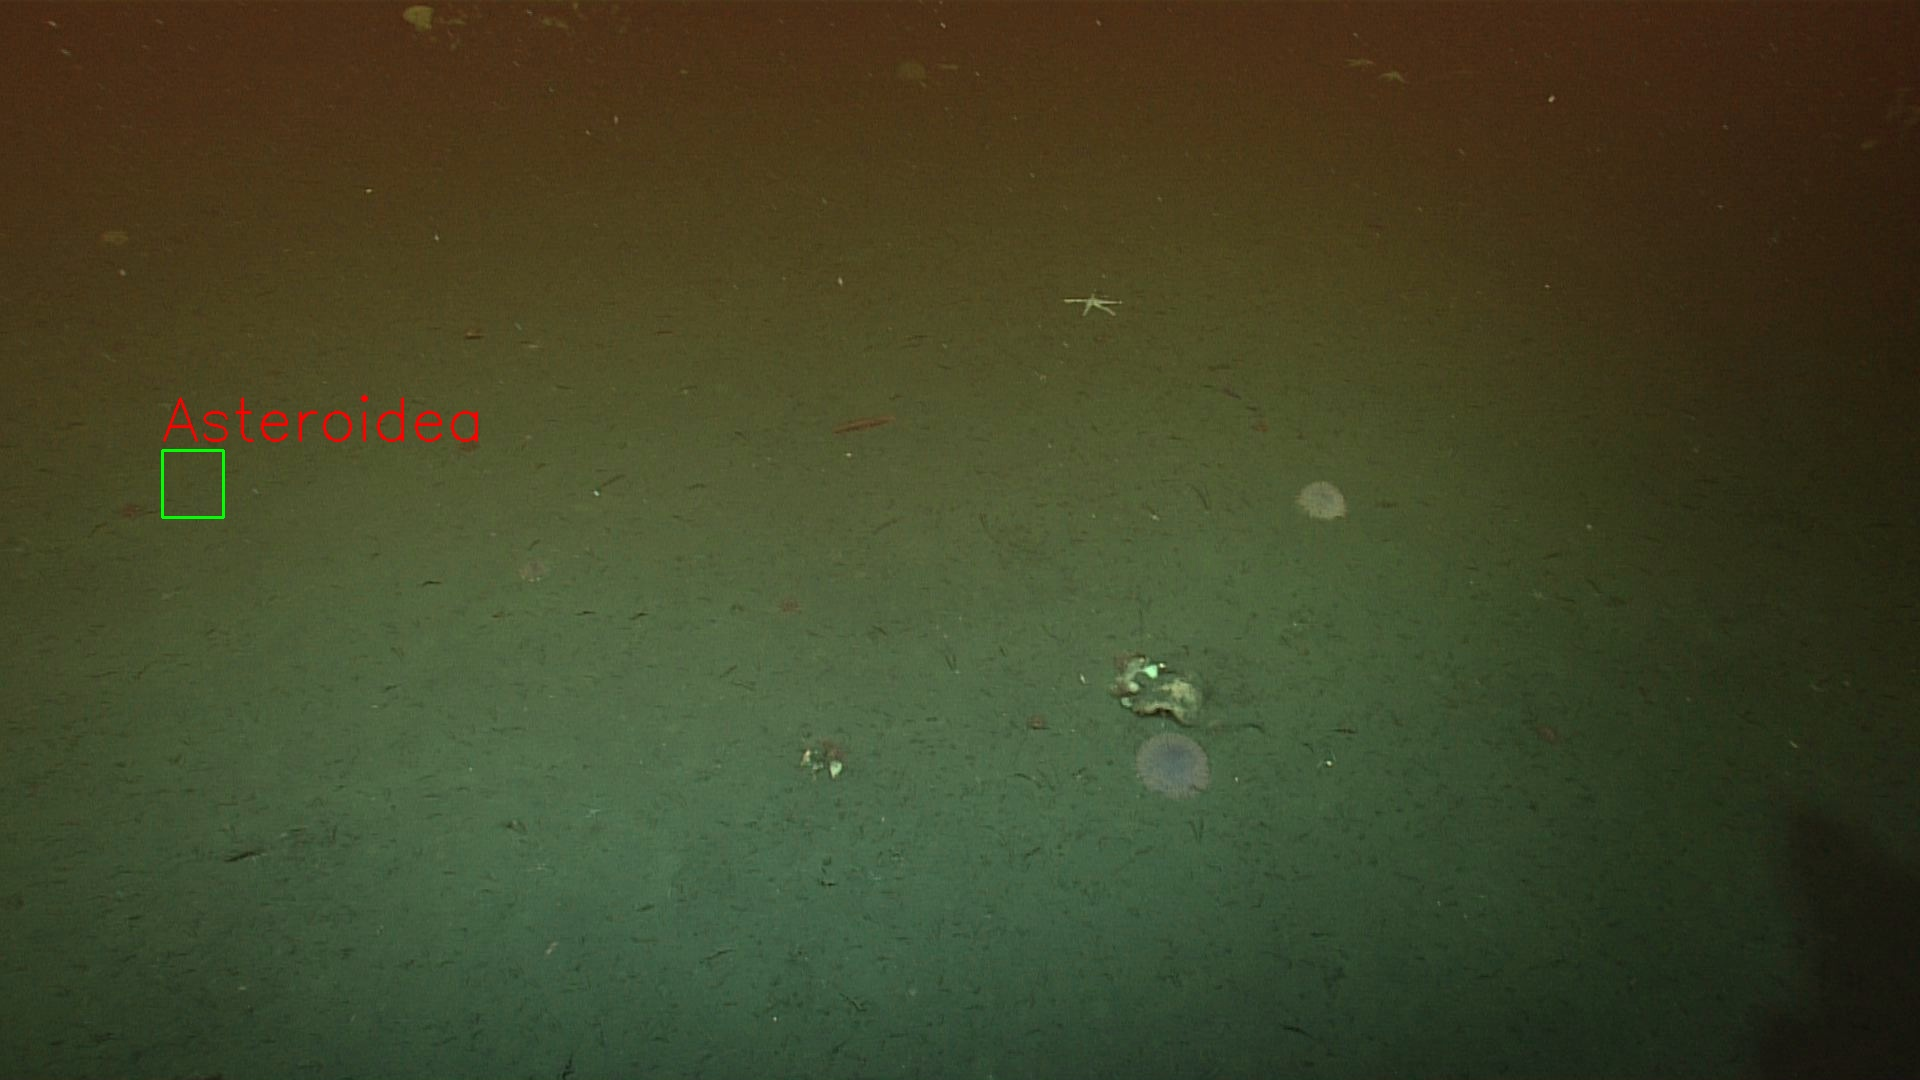

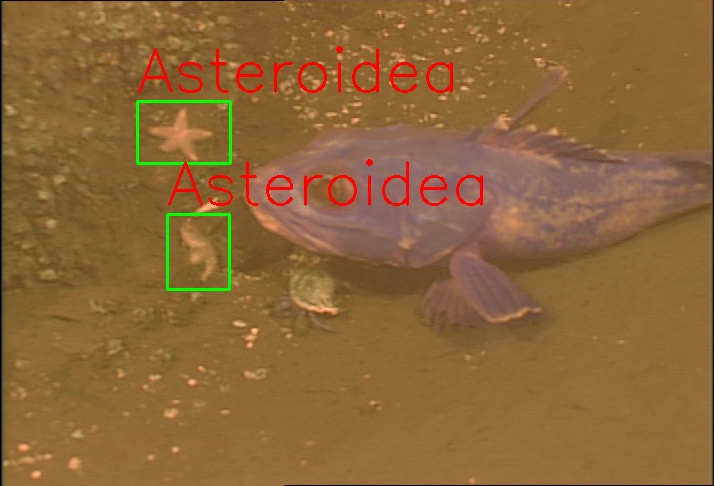

In [18]:
## Sample images for training here

number_to_choose = 2

image_dir = os.path.join(data_directory, 'images', train_dir)
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

random_images = np.random.choice(image_files, number_to_choose, replace=False)

for name in random_images:
    uid, png = os.path.splitext(name)

    image_path = os.path.join(image_dir, name)
    image = cv2.imread(image_path)
    bboxes = parse_txt(os.path.join(data_directory, 'labels', train_dir, f"{uid}.txt"), image.shape)
    
    draw_boxes(image, bboxes)

## Train a YOLOv8 Model

In [19]:
if fresh_mode:
    model = YOLO('yolov8n.yaml').load('yolov8n.pt')
    
    model_config = os.path.join(data_directory, "data.yml")
    results = model.train(data=model_config, epochs=1)
else:
    # TODO-KM: Get if src/bestYOLO.pt exists else use use default yolov8n.pt
    model = YOLO('yolov8n.pt')


0: 512x736 1 bird, 412.6ms
Speed: 19.7ms preprocess, 412.6ms inference, 23.9ms postprocess per image at shape (1, 3, 512, 736)
Results saved to runs\detect\predict4


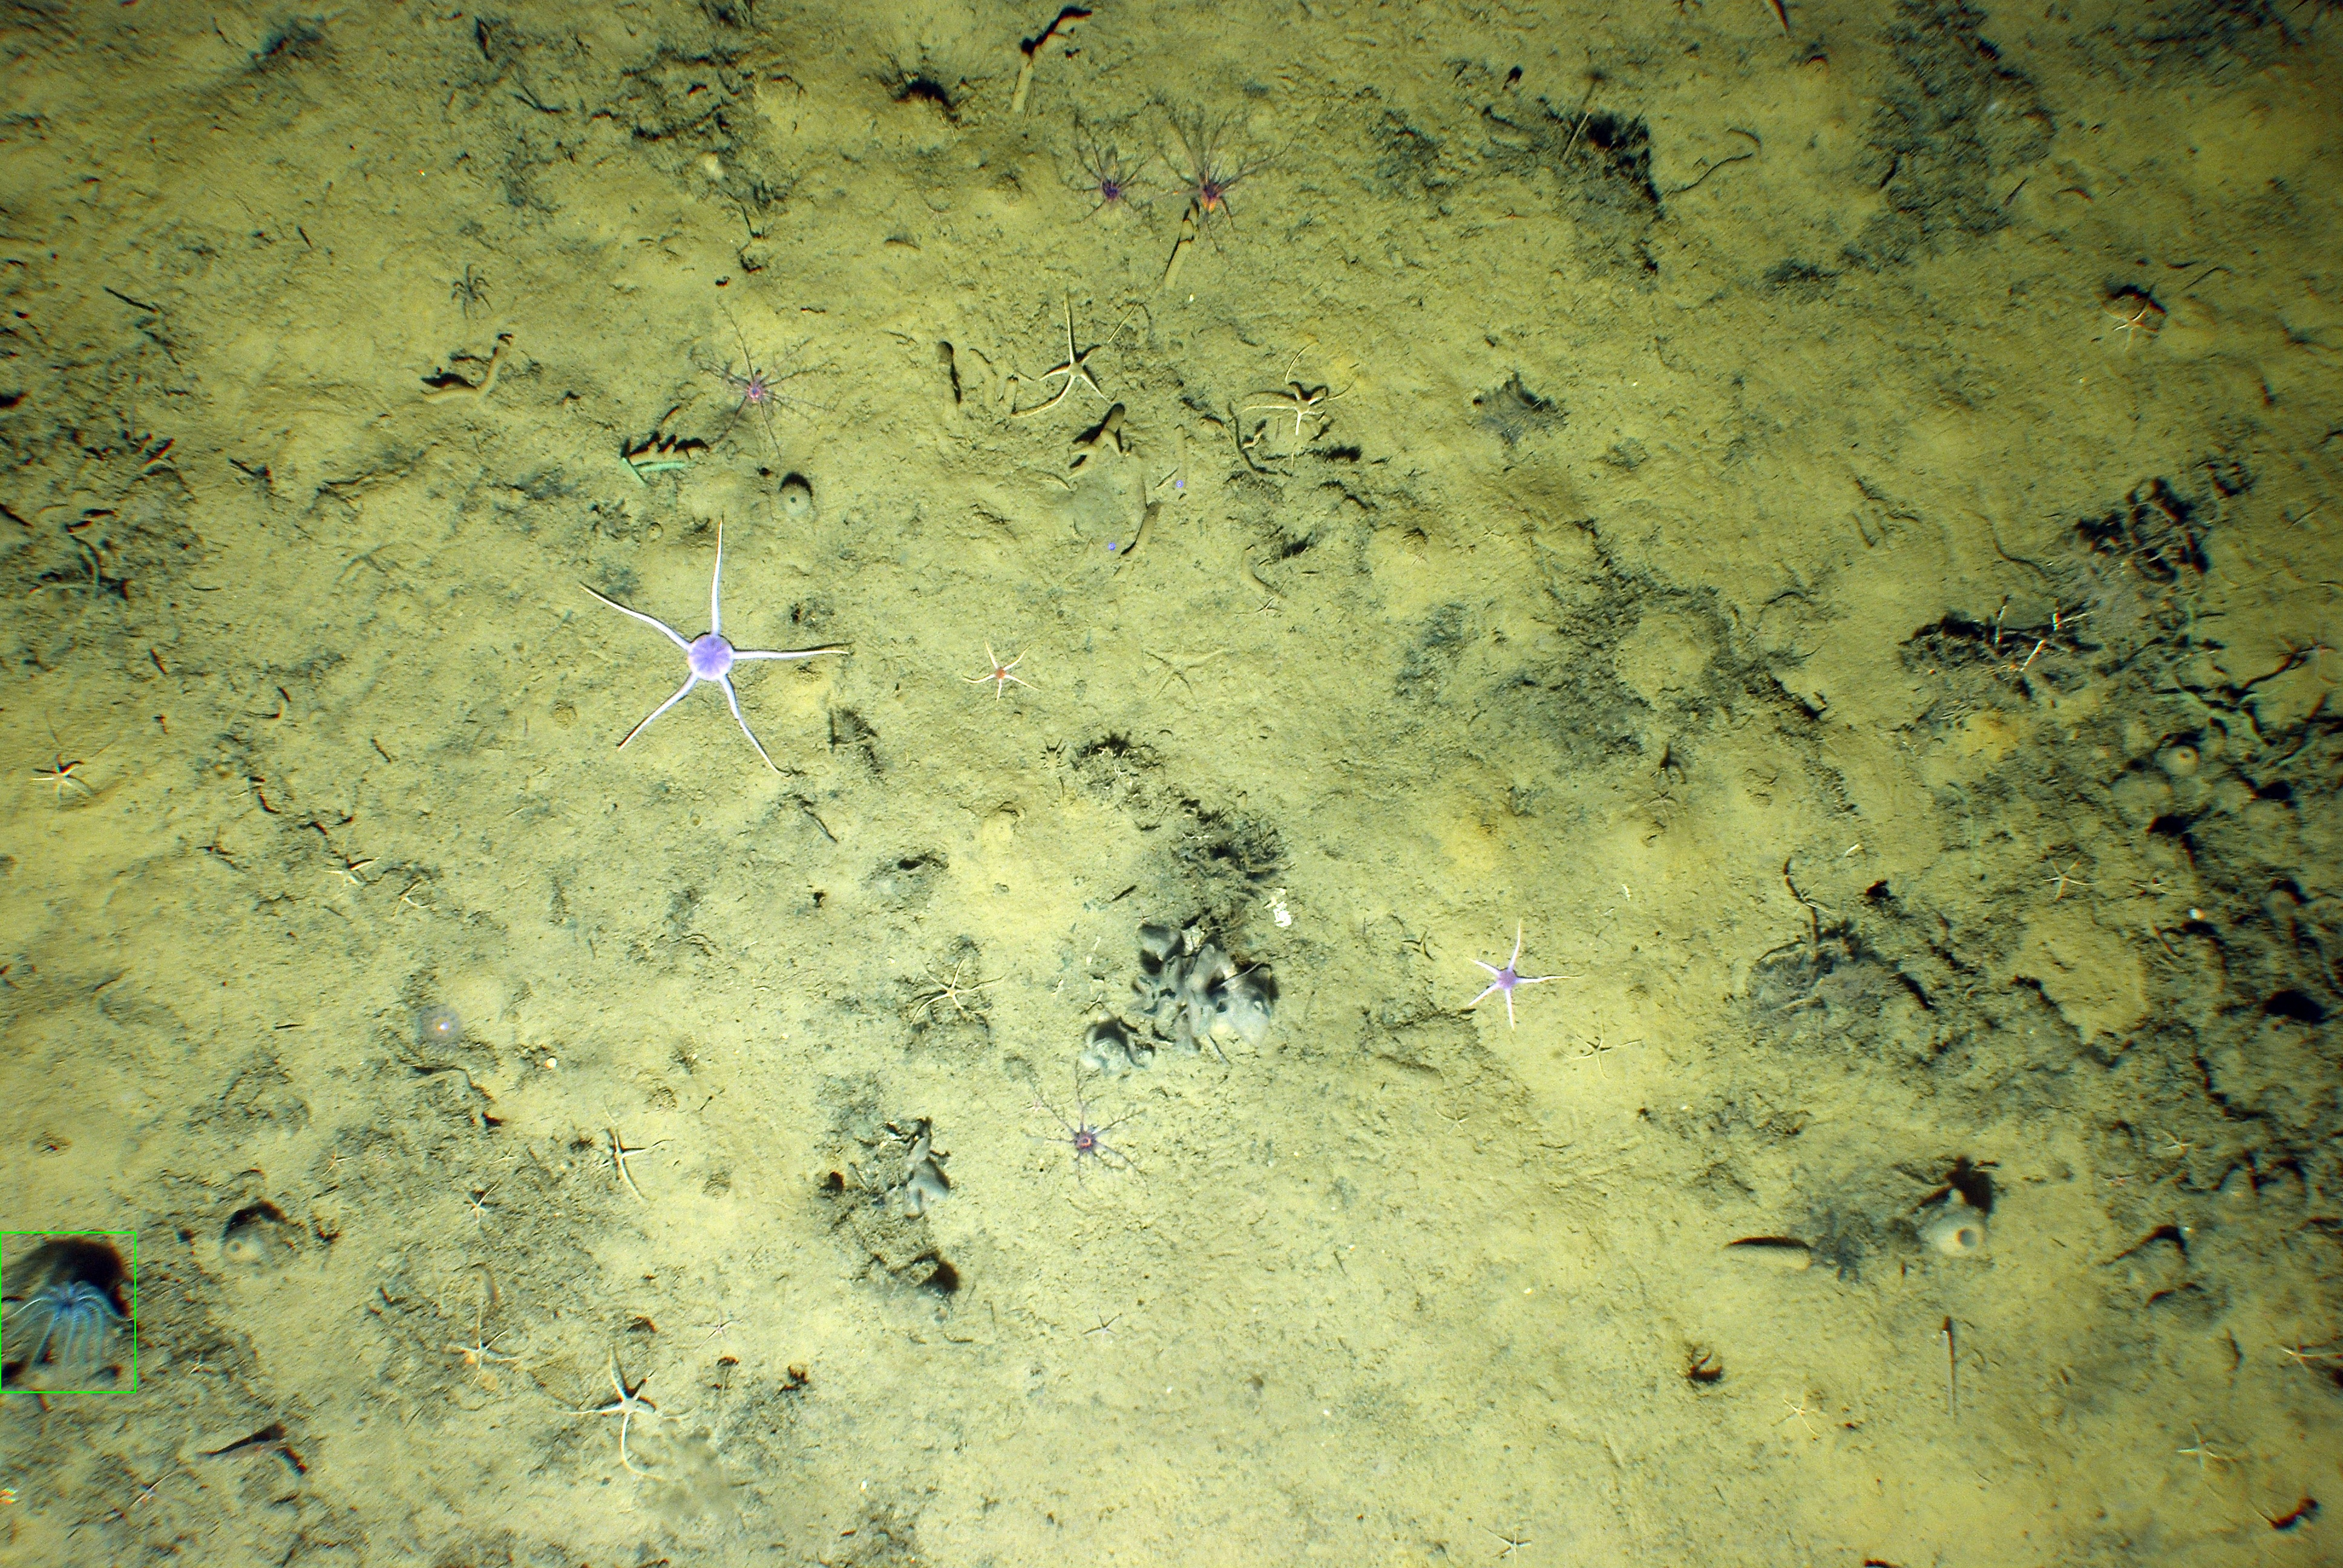

In [20]:

image = cv2.imread('DSC_0278.jpg')
prediction = model(image, imgsz=[512, 736], conf=0.1, save=True)

for bbox in prediction[0].boxes:
    x1, y1, x2, y2 = bbox.xyxy.cpu()[0].numpy()
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# Convert the image to RGB format for displaying in the notebook
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes in the notebook
display(Image(data=cv2.imencode('.jpg', image_rgb)[1].tobytes()))

# Train an RCNN model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_home = os.path.join('torch', 'torchvision_models')
os.environ['TORCH_HOME'] = torch_home
os.makedirs(torch_home, exist_ok=True)

In [22]:
model = model.to(device)

In [23]:
# Placeholder for training visualizations
class TrainingRun:
    def nothing():
        return

In [124]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import xml.etree.ElementTree as ET

class CustomVOCDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join(img_dir, train_dir)
        self.label_dir = os.path.join(label_dir, train_dir)

        self.max_size = 8

        self.image_files = [filename for filename in os.listdir(self.image_dir) if filename.endswith('.png')][3:7]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        
        image = cv2.imread(img_name)
        image = cv2.resize(image, (224, 224))[:,:,:3]
        image = np.transpose(image, (2, 0, 1))

        annotation_file = os.path.join(self.label_dir, os.path.splitext(self.image_files[idx])[0] + '.xml')

        tree = ET.parse(annotation_file)
        root = tree.getroot()
        boxes = []
        labels = []

        for obj in root.iter("object"):
            label = obj.find("name").text
            labels.append(label)
            bndbox = obj.find("bndbox")
            xmin = float(bndbox.find("xmin").text)
            ymin = float(bndbox.find("ymin").text)
            xmax = float(bndbox.find("xmax").text)
            ymax = float(bndbox.find("ymax").text)

            if xmin > xmax:
                t_min = xmax
                xmax = xmin
                xmin = t_min
            if ymin > ymax:
                t_min = ymax
                ymax = ymin
                ymin = t_min

            boxes.append([xmin, ymin, xmax, ymax])

        padded_boxes = torch.tensor([0, 0, 224, 224], dtype=torch.float32).repeat(self.max_size, 1)
        padded_labels = torch.zeros(self.max_size, dtype=torch.int64)
    
        # Copy the original boxes and labels into the padded tensors
        padded_boxes[-len(boxes):] = torch.tensor(boxes, dtype=torch.float32)
        padded_labels[-len(boxes):] = torch.tensor([int(concepts_to_include.index(label) + 1) for label in labels], dtype=torch.int64)
        
        target = {
            "boxes": padded_boxes,
            "labels": padded_labels
        }

        return torch.from_numpy(image / 255.0), target

In [125]:
from torch.utils.data import DataLoader
from torchvision.ops import box_iou

dataset = CustomVOCDataset()
loader = DataLoader(dataset=dataset, batch_size=2)

## Classifier class

In [40]:
class BenthicResNetClassifier(torch.nn.Module):
    # https://www.kdnuggets.com/2023/06/practical-guide-transfer-learning-pytorch.html
    def __init__(self, load_pretrained=True):
        super().__init__()
        self.new_layers = []

        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT')
        
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features        
        new_classifier = FastRCNNPredictor(
            in_features, len(concepts_to_include)
        )

        self.new_layers = [new_classifier]
        self.model.roi_heads.box_predictor = new_classifier


        # Dummy Param to be able to check the device on which this model is.
        # From https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently
        self.dummy_param = torch.nn.Parameter(torch.empty(0))
        
        # Initialize metrics buffer. element 0 is loss, and element 1 is accuracy.
        self.register_buffer("train_metrics", torch.tensor([float("inf"), 0.0]))
        self.register_buffer("val_metrics", torch.tensor([float("inf"), 0.0]))
        

    def forward(self, image, targets):
        return self.model(image, targets)
    
    def update_metrics(self, run_type, loss, accuracy):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        if loss is not None:
            metrics[0] = loss
        if accuracy is not None:
            metrics[1] = accuracy

    def get_metrics(self, run_type):
        metrics = self.train_metrics if run_type == "train" else self.val_metrics
        return dict(zip(["loss", "accuracy"], metrics.tolist()))

    def fine_tune(self, extract=True):
        # The requires_grad parameter controls whether this parameter is
        # trainable during model training.
        m = self.model
        for p in m.parameters():
            p.requires_grad = False

        if extract:
            for l in self.new_layers:
                for p in l.parameters():
                    p.requires_grad = True
                    
        else:
            for p in m.parameters():
                p.requires_grad = True

    def train_one_epoch(self, data_loader, optimizer, epoch=1):
        """Train this model for a single epoch. Return the loss computed
        during this epoch.
        """
        device = self.dummy_param.device
        criterion = torch.nn.CrossEntropyLoss()
        running_loss = 0.0
        num_batches = 0

        for inputs, targets in data_loader:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = self.model(inputs, targets)
            loss = criterion(outputs, targets)

            running_loss, num_batches = running_loss + loss.item(), num_batches + 1
            loss.backward()
            optimizer.step()

        print(f"[{epoch}] Train Loss: {running_loss / num_batches:0.5f}")
        return running_loss / num_batches

    def evaluate(self, data_loader, epoch, run_type):
        """Evaluate the model on the specified dataset (provided using the DataLoader
        instance). Return the loss and accuracy.
        """
        device = self.dummy_param.device
        criterion = torch.nn.CrossEntropyLoss()
        running_loss = 0.0
        running_accuracy = 0.0
        num_batches = 0
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = self(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            num_batches += 1
            running_accuracy += box_iou(outputs, targets).item()

        print(f"[{epoch}] {run_type} Loss: {running_loss / num_batches:.5f}, Accuracy: {running_accuracy / num_batches:.5f}")
        return running_loss / num_batches, running_accuracy / num_batches
    
    def train_multiple_epochs_and_save_best_checkpoint(
        self,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        epochs,
        filename,
        training_run,
    ):
        """Train this model for multiple epochs. The caller is expected to have frozen
        the layers that should not be trained. We run training for "epochs" epochs.
        The model with the best val accuracy is saved after every epoch.
        
        After every epoch, we also save the train/val loss and accuracy.
        """
        best_val_accuracy = 0.0
        for epoch in range(1, epochs + 1):
            self.train()
            self.train_one_epoch(train_loader, optimizer, epoch)

            # Evaluate accuracy on the train dataset.
            self.eval()            
            with torch.inference_mode():
                train_loss, train_acc = self.evaluate(train_loader, epoch, "Train")
                training_run.train_loss.append(train_loss)
                training_run.train_accuracy.append(train_acc)

            # Evaluate accuracy on the val dataset.
            self.eval()
            with torch.inference_mode():
                val_loss, val_acc = self.evaluate(val_loader, epoch, "Val")
                training_run.val_loss.append(val_loss)
                training_run.val_accuracy.append(val_acc)
                if val_acc > best_val_accuracy:
                    # Save this checkpoint.
                    print(f"Current valdation accuracy {val_acc*100.0:.2f} is better than previous best of {best_val_accuracy*100.0:.2f}. Saving checkpoint.")
                    self.update_metrics("train", train_loss, train_acc)
                    self.update_metrics("val", val_loss, val_acc)
                    torch.save(self.state_dict(), filename)
                    best_val_accuracy = val_acc
            # end with
            
            scheduler.step()

    def get_optimizer_params(self):
        """This method is used only during model fine-tuning when we need to
        set a linear or expotentially decaying learning rate (LR) for the
        layers in the model. We exponentially decay the learning rate as we
        move away from the last output layer.
        """
        options = []

        layers = ['conv1', 'bn1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
        lr = 0.0001
        for layer_name in reversed(layers):
            options.append({
                "params": getattr(self.model, layer_name).parameters(),
                'lr': lr,
            })
            lr = lr / 3.0

        return options

## Still testing

In [126]:
dataset[1]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64),
 {'boxes': tensor([[  0.,   0., 224., 224.],
          [  0.,   0., 224., 224.],
          [  0.,   0., 224., 224.],
          [  0.,   0., 224., 224.],
          [  0.,

In [127]:
for images, targets in loader: 

    print('\nbefore')
    print(targets)
    
    images = list(image.to(device=device, dtype=torch.float) for image in images)
    targets = [dict(zip(targets,t)) for t in zip(*targets.values())]
    
    print('\n after')
    print(targets)



before
{'boxes': tensor([[[  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [315., 365., 339., 389.],
         [186., 198., 200., 211.],
         [315., 165., 337., 185.],
         [520., 390., 534., 404.],
         [105., 189., 122., 206.],
         [555., 270., 573., 286.]],

        [[  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [  0.,   0., 224., 224.],
         [560., 596., 632., 655.]]]), 'labels': tensor([[0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1]])}

 after
[{'boxes': tensor([[  0.,   0., 224., 224.],
        [  0.,   0., 224., 224.],
        [315., 365., 339., 389.],
        [186., 198., 200., 211.],
        [315., 165., 337., 185.],
        [520., 390., 534., 404.],
        [105., 189., 122., 206.],
        [555., 270., 573., 286.]]), 'labels': tensor([0, 0, 1, 1, 1, 1, 1, 1])},

In [72]:
from torchinfo import summary

viz_model = BenthicResNetClassifier(False)
viz_model.fine_tune(True)

for i, p in enumerate(viz_model.named_parameters()):
    if p[1].requires_grad:
        print(f"Parameter number {i} named {p[0]} is available for training")

print('\n\n')
print(viz_model)

Parameter number 0 named dummy_param is available for training
Parameter number 80 named model.roi_heads.box_predictor.cls_score.weight is available for training
Parameter number 81 named model.roi_heads.box_predictor.cls_score.bias is available for training
Parameter number 82 named model.roi_heads.box_predictor.bbox_pred.weight is available for training
Parameter number 83 named model.roi_heads.box_predictor.bbox_pred.bias is available for training



BenthicResNetClassifier(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding

Let's evaluate our base pretrained model

In [139]:
from torchvision.ops import box_iou

rcnn_eval_model = BenthicResNetClassifier(True)
rcnn_eval_model.eval().to(device)

iou_values = []
for images, targets in loader:
    images = list(image.to(device=device, dtype=torch.float) for image in images)
    targets = [dict(zip(targets,t)) for t in zip(*targets.values())]

    with torch.no_grad():
        predictions = rcnn_eval_model(images, targets)

    for prediction, target in zip(predictions, targets):
        predicted_boxes = prediction['boxes']
        target_boxes = target['boxes']
        iou = box_iou(predicted_boxes, target_boxes)
        iou_values.append(iou)
        
mean_iou = np.mean(iou_values)
print("Mean IoU:", mean_iou)

Mean IoU: 0.017735524


In [ ]:
best_cp_path = f'RCNN_best.pt'

print(f"Running ...\n")
rcnn_model = BenthicResNetClassifier(True)
rcnn_model.to(device)

optimizer = torch.optim.Adam(rcnn_model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)
accuracy = MulticlassAccuracy(num_classes=102, average='micro').to(device)

# First freeze all the weights except for the newly added Linear layer.
fc.fine_tune(FineTuneType.NEW_LAYERS)

best_test_accuracy = 0.0
training_run = TrainingRun()
training_runs[backbone] = training_run

fc.train_multiple_epochs_and_save_best_checkpoint(
    flowers_train_loader,
    flowers_test_loader,
    accuracy,
    optimizer,
    scheduler,
    feature_extract_epochs,
    best_cp_path,
    training_run,
)

print(f"Done with feature extraction for {backbone}-based model. Ran for {feature_extract_epochs} epochs.")

best_val_accuracy = fc.get_metrics("val")['accuracy']
print(f"[{backbone}] Best val accuracy after feature extraction is {best_val_accuracy}\n")
print(f"Running fine-tuning for {fine_tune_epochs} epochs")

# Set all the parameters to be trainable.
fc.fine_tune(FineTuneType.ALL)

optimizer = torch.optim.Adam(fc.get_optimizer_params(), lr=1e-8)
# Every 2 steps reduce the LR to 70% of the previous value.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

fc.train_multiple_epochs_and_save_best_checkpoint(
    flowers_train_loader,
    flowers_test_loader,
    accuracy,
    optimizer,
    scheduler,
    fine_tune_epochs,
    best_cp_path,
    training_run,
)

best_val_accuracy = fc.get_metrics("val")['accuracy']
print(f"[{backbone}] Best val accuracy after fine-tuning is {best_val_accuracy}\n")

In [ ]:
import torch.optim as optim

#fc_test = BenthicResNetClassifier(load_pretrained=True)
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)

num_epochs = 2
for epoch in range(num_epochs):    
    epoch_progress = IntProgress(min=0, max=len(data_loader))
    display(epoch_progress)

    for images, targets in data_loader:   
        epoch_progress.value += 1

        images = list(image.to(device=device, dtype=torch.float) for image in images)
        targets = [{k: v[0].to(device) for k, v in targets.items()}]
        print(targets)
        
        loss_dict = fc_test(images, targets)
        sum_loss = sum(loss for loss in loss_dict.values())
    
        sum_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
model.eval()

image = cv2.imread('DSC_0272.jpg')[:,:,:3]
image = np.transpose(image, (2, 0, 1))

input_image = torch.from_numpy(image / 255.0).to(dtype=torch.float32)
input_image = input_image.unsqueeze_(0)

with torch.no_grad():
    model.eval()
    output = model(input_image)

In [ ]:
output